## Attention is All You Need

Transformer đã được nhiều người chú ý trong 5 năm gần đây. Tài liệu như nơi giải thích implement từng dòng trong kiến trúc này

In [6]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
# from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
# from torchtext.vocab import build_vocab_from_iterator
# import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [7]:
# Some convenience helper functions used throughout the notebook
def is_interactive_notebook():
    return __name__ == "__main__"

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLE:
        return fn(*args)

def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)

class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None
    
    def step(self):
        None
        
    def zero_grad(self, set_to_none=False):
        None

class DummyScheduler:
    def step(self):
        None



# Background
Mục tiêu giảm tính toán tuần tự cũng như mở rộng sử dụng GPU 
* Self-attention được một số người gọi là intra-attention. cơ chế attention liên quan các vị trí của chuỗi để tính toán biểu diễn chuỗi.
* Được sử dụng trong nhiều task MRC, Summary, learning task-independent sentence 

# Model Architecture
Hầu hết các mô hình dịch sẽ gồm 2 phần encoder-decoder . model auto-regressive sẽ sử dụng các ký tự đã tạo trước đó làm đầu vào bổ sung cho model generate text


In [ ]:
Class EncoderDecoder(nn.Module):
    """
    a standard Encoder-Decoder architecture. Base for this and many other models.
    """
    
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        """take in and progress masked src, target sequence"""
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

    

* Transformer tuân theo kiến trúc tổng thể này bằng cách xếp self-attention và point-wise, fully connected layer cho cả encoder và decoder

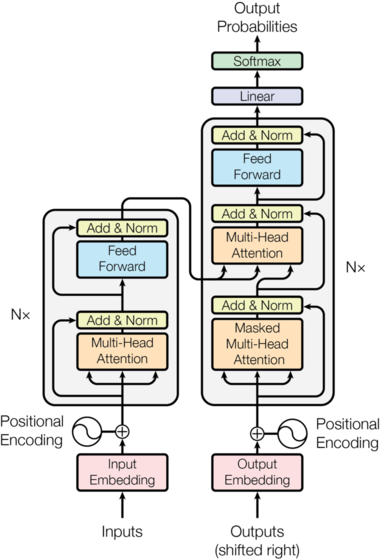

In [14]:
from PIL import Image
Image.open('../images/index.png')

In [16]:
def clones(module, N):
    "produce N identical layers"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        "Pass the input through each layer in turn"
        for layer in self.layers:
            x = layer(x, mask)
            return self.norm(x)

In [ ]:
# residual connection around each of the two sub-layers
class LayerNorm(nn.Module):
    "Construct a layernorm module"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    

In [ ]:
class SublayerConnection(nn.Module):
    """
    residual connection followed by a layer norm
    Note for code simplicity the norm is first as opposed to last
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))